In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  
import matplotlib
import seaborn as sns
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import pandas as pd
import networkx as nx
import random
import operator

In [2]:
def atom_graph(g):
    # determine if subgroup is attached
    h = nx.Graph()
    v = []
    tris = {}
    edges = {}
    for node,data in g.nodes(data=True):
        g.node[node]['atoms'] = set([])

    for node,data in g.nodes(data=True):
        # triplet
        for node in nx.nodes(g):
            for each in g[node]:
                if each == node: continue
                neighbors = set(g[node]).intersection(set(g[each]))
                #print(node, each, neighbors, set(g[node]), g[each], set(g[each]))
                for neighbor in neighbors:
                    t = tuple(sorted((node, each, neighbor)))
                    if t not in list(tris.keys()):
                        nr = len(h.nodes())
                        tris[t] = nr
                        h.add_node(nr)
                        g.node[node]['atoms'].add(nr)
                        g.node[each]['atoms'].add(nr)
                        g.node[neighbor]['atoms'].add(nr)
                        print(node, each, neighbor)
                        for k in tris:
                            if len(set(k).intersection(set(t))) == 2:
                                h.add_edge(nr, tris[k])
                                edges[tuple(sorted(set(k).intersection(set(t))))] = nr

    if nx.cycle_basis(h):
        extra_nodes = set(h.nodes()).difference(set(np.concatenate(nx.cycle_basis(h))))
        for n in extra_nodes:
            h.remove_node(n)
    return h

def build_initial_pdb(h, pos):
    v = []
    count = 1
    atom_xyz = {}
    atom_names = {}
    line = "ATOM %6i %4s%4s%6i    %8.3f%8.3f%8.3f%6.2f%6.2f      %-4s\n"
    atomtype = 'C'
    residue = 'GP'
    resnr = 1
    x = 0
    y = 0
    z = 0
    bfactor = 0
    segment = 'GP'

    rot = lambda theta: np.matrix(((np.cos(np.radians(theta)), -np.sin(np.radians(theta)), 0), 
                                    (np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0),
                                    (0, 0, 0)))
    fp = open('junk.pdb', 'w')
    for i,node in enumerate(g.nodes()):
        atoms = g.node[node]['atoms']
        if not atoms: continue
        source = sorted(atoms)[0]
        u = np.array((1.39, 0, 0))
        theta = 0
        center = (0.0,0.0)
        
        for atom in sorted(atoms):
            if atom in atom_xyz: continue
            if atom not in pos: continue
            v = np.asarray(np.dot(u,rot(theta)))[0,:]
            x = v[0] + center[0]
            y = v[1] + center[1]
            x = pos[atom][0]/10
            y = pos[atom][1]/10

            atomtype = "C%d" % count
            atom_names[atom] = atomtype
            atomdata = (count,atomtype,residue,resnr,x,y,z,0.0,bfactor,segment[:4])
            atom_xyz[atom] = np.array((x,y,z))
            #print(line % atomdata)
            fp.write(line % atomdata)
            count += 1
            theta += 60
    fp.close()
    return atom_names

def build_topology(h, atom_names):
    v = []
    atom_names = {}
    count = 1
    fp = open('graphene.rtf', 'w')
    fp.write("""*  --------------------------------------------------------------------------  *
*          GRAPHENE                                                            *
*  --------------------------------------------------------------------------  *
*
36  1

MASS    23 HGR61    1.00800  ! aromatic H
MASS    61 CG2R61  12.01100  ! 6-mem aromatic C

DEFA FIRS NONE LAST NONE
AUTO ANGLES DIHE

RESI GP 0.0
""")
    for atom in h.nodes():
        if h.degree(atom) < 1: continue
        atom_names[atom] = "C%d" % count
        count += 1
        fp.write("ATOM %s CG2R61 0.0\n" % atom_names[atom])
        
    for atom_edge in h.edges():
        fp.write("BOND %s %s\n" % (atom_names[atom_edge[0]], atom_names[atom_edge[1]]))
    fp.close()

In [3]:
def add_unit(g, nodetype={'vertices': 6}):
    if len(g.nodes()) == 0:
        nodenr = 0
        g.add_node(0, nodetype)
    else:
        nodenr = max(g.nodes())+1
        g.add_node(nodenr, nodetype)
    return nodenr

def add_unit_neighbor(g, neighbor, nodetype={'vertices': 6}):
    if g.degree(neighbor) == g.node[neighbor]['vertices']:
        check_closure(g, neighbor)
        return False
    
    if random.random() <= 0.1 and g.node[neighbor]['vertices'] == 6:
        nodetype = {'vertices': 5}
        if random.random() < 0.5: nodetype = {'vertices': 7}
    
    near_hexagon = True
    nodenr = add_unit(g, nodetype)
    #neighbor = find_neighbor(g)
    g.add_edge(neighbor, nodenr)
    nn = find_neighbor_neighbor(g, nodenr, neighbor)
    if nn:
        g.add_edge(nodenr, nn)
        g.add_edge(neighbor, nn)
        if g.node[nn]['vertices'] != 6: near_hexagon = False
    
    if g.degree(neighbor) == g.node[neighbor]['vertices']:
        nn = find_neighbor_neighbor(g, nodenr, neighbor)
        if nn:
            g.add_edge(nodenr, nn)
            if g.node[nn]['vertices'] != 6: near_hexagon = False

    if not near_hexagon:
        g.node[nodenr]['vertices'] = 6

def find_neighbor(g):
    for n in g.nodes():
        if g.node[n]['vertices'] != g.degree(n):
            return n

def find_neighbor_neighbor(g, node, neighbor):
    neighbors = []
    for n in set(g[neighbor]):
        if n == node or g.node[n]['vertices'] == g.degree(n):
            continue
        shared_neighbors = set(g[n]).intersection(set(g[neighbor]))
        #print(node, neighbor, n, g[n], shared_neighbors)
        if len(shared_neighbors) < 2:
            neighbors.append(n)
    
    if neighbors:
        return neighbors[0]
    else:
        return None

def check_closure(g, node):
    h = g.subgraph(g[node])
    if nx.cycle_basis(h): return True
    sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
    nodes = [n[0] for n in sorted_nodes[:2] if n[1] == 1]
    if len(nodes) == 2:
        if g.node[nodes[0]]['vertices'] > g.degree(nodes[0]) and \
           g.node[nodes[1]]['vertices'] > g.degree(nodes[1]):
            g.add_edge(nodes[0], nodes[1])
            return False

        if g.node[nodes[0]]['vertices'] > g.degree(nodes[0]) and \
            g.node[nodes[1]]['vertices'] == g.degree(nodes[1]):
            h = g.subgraph(g[nodes[1]])
            sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
            xnode = [n[0] for n in sorted_nodes if n[1] == 1 and n[0] not in [nodes[0], nodes[1], node]].pop()
            for n in g[xnode]:
                if n in [nodes[1], node]: continue
                g.add_edge(nodes[0], n)
            g.remove_node(xnode)
            return False

        if g.node[nodes[0]]['vertices'] == g.degree(nodes[0]) and \
            g.node[nodes[1]]['vertices'] > g.degree(nodes[1]):
            h = g.subgraph(g[nodes[0]])
            sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
            xnode = [n[0] for n in sorted_nodes if n[1] == 1 and n[0] not in [nodes[0], nodes[1], node]].pop()
            for n in g[xnode]:
                if n in [nodes[0], node]: continue
                g.add_edge(nodes[1], n)
            g.remove_node(xnode)
            return False

In [4]:
g = nx.Graph()
add_unit(g)
closed_node = []
for i in range(150):
    node = find_neighbor(g)
    nodetype = g.node[node]['vertices']
    for j in range(nodetype):
        add_unit_neighbor(g, node)
    
    for n in g.nodes():
        if n not in closed_node and g.node[n]['vertices'] == g.degree(n):
            check_closure(g, n)
            closed_node.append(n)
#g.edges()

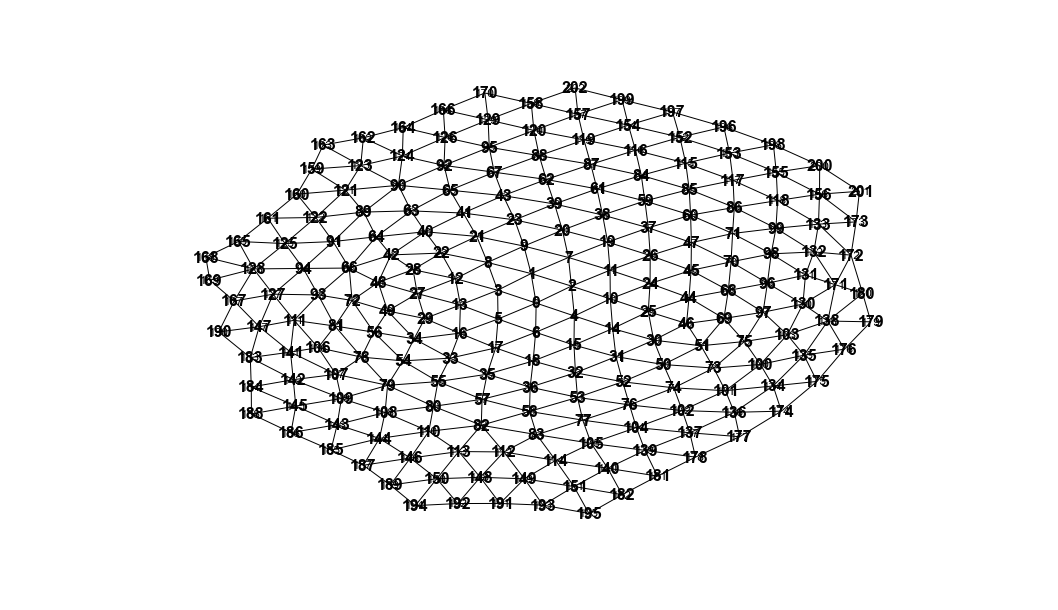

In [5]:
plt.figure(1,figsize=(14,8))
pos=nx.graphviz_layout(g, prog='neato')
#pos=nx.spring_layout(g)
nx.draw(g, pos, node_size=0, with_labels=True)
nx.draw_networkx_labels(g,pos,font_size=16,font_family='sans-serif',font_weight='bold')
plt.show()

In [6]:
h = atom_graph(g)
pos=nx.graphviz_layout(h, prog='neato')
atom_names = build_initial_pdb(h, pos)
build_topology(h, atom_names)

0 1 2
0 1 3
0 2 4
0 3 5
0 4 6
0 5 6
1 2 7
1 3 8
1 7 9
1 8 9
2 4 10
2 7 11
2 10 11
3 5 13
3 8 12
3 12 13
4 6 15
4 10 14
4 14 15
5 16 17
5 16 13
5 6 17
6 17 18
6 18 15
7 19 11
7 19 20
7 20 9
8 21 9
8 21 22
8 22 12
9 20 23
9 21 23
10 24 25
10 24 11
10 25 14
11 19 26
11 24 26
12 22 28
12 27 28
12 27 13
13 16 29
13 27 29
14 25 30
14 31 30
14 31 15
15 32 18
15 32 31
16 17 33
16 34 33
16 34 29
17 33 35
17 18 35
18 32 36
18 35 36
19 20 38
19 37 26
19 37 38
20 38 39
20 23 39
21 40 41
21 40 22
21 41 23
22 40 42
22 42 28
23 43 41
23 43 39
24 25 44
24 44 45
24 26 45
25 46 44
25 46 30
26 37 47
26 45 47
27 48 49
27 48 28
27 49 29
28 48 42
29 49 34
30 50 51
30 50 31
30 51 46
31 32 52
31 50 52
32 52 53
32 53 36
33 34 54
33 35 55
33 54 55
34 54 56
34 49 56
35 36 57
35 55 57
36 53 58
36 57 58
37 38 59
37 59 60
37 60 47
38 39 61
38 59 61
39 43 62
39 61 62
40 64 42
40 64 63
40 41 63
41 65 43
41 65 63
42 48 66
42 64 66
43 65 67
43 67 62
44 68 69
44 68 45
44 69 46
45 68 70
45 70 47
46 51 69
47 70 71
47 71 6